In [ ]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
from torch.nn.modules import conv
from torch.nn.modules.utils import _pair
import math
from functools import partial
%matplotlib inline
import torchvision.transforms as transforms


In [ ]:
#iteratively solve for inverse sqrt of a matrix
def isqrt_newton_schulz_autograd(A, numIters):
    dim = A.shape[0]
    normA=A.norm()
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z@Y)
        Y = Y@T
        Z = T@Z
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)
    return A_isqrt


In [ ]:
def isqrt_newton_schulz_autograd_batch(A, numIters):
    batchSize,dim,_ = A.shape
    normA=A.view(batchSize, -1).norm(2, 1).view(batchSize, 1, 1)
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z.bmm(Y))
        Y = Y.bmm(T)
        Z = T.bmm(Z)
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)

    return A_isqrt

In [ ]:
#deconvolve channels
class ChannelDeconv(nn.Module):
    def __init__(self,  block, eps=1e-2,n_iter=5,momentum=0.1,sampling_stride=3):
        super(ChannelDeconv, self).__init__()

        self.eps = eps
        self.n_iter=n_iter
        self.momentum=momentum
        self.block = block

        self.register_buffer('running_mean1', torch.zeros(block, 1))
        #self.register_buffer('running_cov', torch.eye(block))
        self.register_buffer('running_deconv', torch.eye(block))
        self.register_buffer('running_mean2', torch.zeros(1, 1))
        self.register_buffer('running_var', torch.ones(1, 1))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        self.sampling_stride=sampling_stride
    def forward(self, x):
        x_shape = x.shape
        if len(x.shape)==2:
            x=x.view(x.shape[0],x.shape[1],1,1)
        if len(x.shape)==3:
            print('Error! Unsupprted tensor shape.')

        N, C, H, W = x.size()
        B = self.block

        #take the first c channels out for deconv
        c=int(C/B)*B
        if c==0:
            print('Error! block should be set smaller.')

        #step 1. remove mean
        if c!=C:
            x1=x[:,:c].permute(1,0,2,3).contiguous().view(B,-1)
        else:
            x1=x.permute(1,0,2,3).contiguous().view(B,-1)

        if self.sampling_stride > 1 and H >= self.sampling_stride and W >= self.sampling_stride:
            x1_s = x1[:,::self.sampling_stride**2]
        else:
            x1_s=x1

        mean1 = x1_s.mean(-1, keepdim=True)

        if self.num_batches_tracked==0:
            self.running_mean1.copy_(mean1.detach())
        if self.training:
            self.running_mean1.mul_(1-self.momentum)
            self.running_mean1.add_(mean1.detach()*self.momentum)
        else:
            mean1 = self.running_mean1

        x1=x1-mean1

        #step 2. calculate deconv@x1 = cov^(-0.5)@x1
        if self.training:
            cov = x1_s @ x1_s.t() / x1_s.shape[1] + self.eps * torch.eye(B, dtype=x.dtype, device=x.device)
            deconv = isqrt_newton_schulz_autograd(cov, self.n_iter)

        if self.num_batches_tracked==0:
            #self.running_cov.copy_(cov.detach())
            self.running_deconv.copy_(deconv.detach())

        if self.training:
            #self.running_cov.mul_(1-self.momentum)
            #self.running_cov.add_(cov.detach()*self.momentum)
            self.running_deconv.mul_(1 - self.momentum)
            self.running_deconv.add_(deconv.detach() * self.momentum)
        else:
            # cov = self.running_cov
            deconv = self.running_deconv

        x1 =deconv@x1

        #reshape to N,c,J,W
        x1 = x1.view(c, N, H, W).contiguous().permute(1,0,2,3)

        # normalize the remaining channels
        if c!=C:
            x_tmp=x[:, c:].view(N,-1)
            if self.sampling_stride > 1 and H>=self.sampling_stride and W>=self.sampling_stride:
                x_s = x_tmp[:, ::self.sampling_stride ** 2]
            else:
                x_s = x_tmp

            mean2=x_s.mean()
            var=x_s.var()

            if self.num_batches_tracked == 0:
                self.running_mean2.copy_(mean2.detach())
                self.running_var.copy_(var.detach())

            if self.training:
                self.running_mean2.mul_(1 - self.momentum)
                self.running_mean2.add_(mean2.detach() * self.momentum)
                self.running_var.mul_(1 - self.momentum)
                self.running_var.add_(var.detach() * self.momentum)
            else:
                mean2 = self.running_mean2
                var = self.running_var

            x_tmp = (x[:, c:] - mean2) / (var + self.eps).sqrt()
            x1 = torch.cat([x1, x_tmp], dim=1)


        if self.training:
            self.num_batches_tracked.add_(1)

        if len(x_shape)==2:
            x1=x1.view(x_shape)
        return x1

In [ ]:
#An alternative implementation
class Delinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=512):
        super(Delinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()



        if block > in_features:
            block = in_features
        else:
            if in_features%block!=0:
                block=math.gcd(block,in_features)
                print('block size set to:', block)
        self.block = block
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.register_buffer('running_mean', torch.zeros(self.block))
        self.register_buffer('running_deconv', torch.eye(self.block))


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):

        if self.training:

            # 1. reshape
            X=input.view(-1, self.block)

            # 2. subtract mean
            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)
            self.running_mean.mul_(1 - self.momentum)
            self.running_mean.add_(X_mean.detach() * self.momentum)

            # 3. calculate COV, COV^(-0.5), then deconv
            # Cov = X.t() @ X / X.shape[0] + self.eps * torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
            Id = torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
            Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
            deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            # track stats for evaluation
            self.running_deconv.mul_(1 - self.momentum)
            self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        w = self.weight.view(-1, self.block) @ deconv
        if self.bias is None:
            b = - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
        else:
            b = self.bias - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)

        w = w.view(self.weight.shape)
        return F.linear(input, w, b)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [ ]:
class FastDeconv(conv._ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,groups=1,bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=64, sampling_stride=3,freeze=False,freeze_iter=100):
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.counter=0
        self.track_running_stats=True
        super(FastDeconv, self).__init__(
            in_channels, out_channels,  _pair(kernel_size), _pair(stride), _pair(padding), _pair(dilation),
            False, _pair(0), groups, bias, padding_mode='zeros')

        if block > in_channels:
            block = in_channels
        else:
            if in_channels%block!=0:
                block=math.gcd(block,in_channels)

        if groups>1:
            #grouped conv
            block=in_channels//groups

        self.block=block

        self.num_features = kernel_size**2 *block
        if groups==1:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_deconv', torch.eye(self.num_features))
        else:
            self.register_buffer('running_mean', torch.zeros(kernel_size ** 2 * in_channels))
            self.register_buffer('running_deconv', torch.eye(self.num_features).repeat(in_channels // block, 1, 1))

        self.sampling_stride=sampling_stride*stride
        self.counter=0
        self.freeze_iter=freeze_iter
        self.freeze=freeze

    def forward(self, x):
        N, C, H, W = x.shape
        B = self.block
        frozen=self.freeze and (self.counter>self.freeze_iter)
        if self.training and self.track_running_stats:
            self.counter+=1
            self.counter %= (self.freeze_iter * 10)

        if self.training and (not frozen):

            # 1. im2col: N x cols x pixels -> N*pixles x cols
            if self.kernel_size[0]>1:
                X = torch.nn.functional.unfold(x, self.kernel_size,self.dilation,self.padding,self.sampling_stride).transpose(1, 2).contiguous()
            else:
                #channel wise
                X = x.permute(0, 2, 3, 1).contiguous().view(-1, C)[::self.sampling_stride**2,:]

            if self.groups==1:
                # (C//B*N*pixels,k*k*B)
                X = X.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1, self.num_features)
            else:
                X=X.view(-1,X.shape[-1])

            # 2. subtract mean
            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)

            # 3. calculate COV, COV^(-0.5), then deconv
            if self.groups==1:
                #Cov = X.t() @ X / X.shape[0] + self.eps * torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Id=torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
                deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            else:
                X = X.view(-1, self.groups, self.num_features).transpose(0, 1)
                Id = torch.eye(self.num_features, dtype=X.dtype, device=X.device).expand(self.groups, self.num_features, self.num_features)
                Cov = torch.baddbmm(self.eps, Id, 1. / X.shape[1], X.transpose(1, 2), X)

                deconv = isqrt_newton_schulz_autograd_batch(Cov, self.n_iter)

            if self.track_running_stats:
                self.running_mean.mul_(1 - self.momentum)
                self.running_mean.add_(X_mean.detach() * self.momentum)
                # track stats for evaluation
                self.running_deconv.mul_(1 - self.momentum)
                self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        #4. X * deconv * conv = X * (deconv * conv)
        if self.groups==1:
            w = self.weight.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1,self.num_features) @ deconv
            b = self.bias - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
            w = w.view(-1, C // B, self.num_features).transpose(1, 2).contiguous()
        else:
            w = self.weight.view(C//B, -1,self.num_features)@deconv
            b = self.bias - (w @ (X_mean.view( -1,self.num_features,1))).view(self.bias.shape)

        w = w.view(self.weight.shape)
        x= F.conv2d(x, w, b, self.stride, self.padding, self.dilation, self.groups)

        return x

In [ ]:
deconv = partial(FastDeconv,bias=True, eps=1e-5, n_iter=5,block=64,sampling_stride=3)
delinear = partial(Delinear, block=16, eps=1e-5,n_iter=5)
channel_deconv = partial(ChannelDeconv, block=16, eps=1e-5, n_iter=5,sampling_stride=3)

In [ ]:
# config
#device = torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [ ]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

In [ ]:
#connect Drive and load data
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='ColorPlantVillage.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('ColorPlantVillage.zip')

f.keys()
!unzip ColorPlantVillage.zip

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomAffine(degrees=10, translate=None, scale=(.9, 1.5), shear=5)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
#Data = ImageFolder('/content/data')
#splitfolders.ratio('/content/data', '/content/data', seed=1337, ratio=(.8, 0.2)) #for ISL dataset
splitfolders.ratio('/content/ColorPlantVillage', '/content/ColorPlantVillage', seed=1337, ratio=(.8, 0.2))

Copying files: 54305 files [00:07, 7023.64 files/s]


In [ ]:
# MNIST dataset
#train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True, transform=simple_transform,  download=True)
#test_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=False, transform=simple_transform)

train = ImageFolder('/content/ColorPlantVillage/train',simple_transform)
valid = ImageFolder('/content/ColorPlantVillage/val',simple_transform)

#train_dataset = ImageFolder('/content/tomato-disease/train',simple_transform)
#test_dataset = ImageFolder('/content/tomato-disease/test',simple_transform)


In [ ]:
print(train.class_to_idx)
print(train.classes)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
imshow(valid[10][0])

In [ ]:
#parameters
num_epochs = 5
num_classes = 38
batch_size = 100
learning_rate = 0.001

In [ ]:
train_data_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, num_workers=2, shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, num_workers=2, shuffle=False)

In [ ]:
# get some random training images from dataset
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

In [ ]:
# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
# Channel Attention Unit (CAU)
class CAU(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(CAU, self).__init__()
        self.feature_extraction = nn.Sequential(
            deconv(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(inplace=True)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.feature_extraction(x)
        g = self.global_avg_pool(feat).view(feat.size(0), feat.size(1), -1)  # (N, C, 1)
        weight = self.fc(g).view(feat.size(0), feat.size(1), 1, 1)
        out = weight * feat
        return out

In [ ]:
# Densely Connected Attention Module (DCAM)
class DCAM(nn.Module):
    def __init__(self, channels):
        super(DCAM, self).__init__()
        self.cau1 = CAU(channels)
        self.cau2 = CAU(channels)
        self.cau3 = CAU(channels)

    def forward(self, x):
        out1 = self.cau1(x)
        out2 = self.cau2(torch.cat([x, out1], dim=1))
        out3 = self.cau3(torch.cat([x, out1, out2], dim=1))
        out = torch.cat([x, out1, out2, out3], dim=1)
        return out


In [ ]:
# Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = deconv(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        return out


In [ ]:
# DCAM-DNet model
class DCAM_DNet(nn.Module):
    def __init__(self, num_classes=38, init_channels=64):
        super(DCAM_DNet, self).__init__()
        self.init_conv = nn.Sequential(
            deconv(in_channels=3, out_channels=init_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.dcam1 = DCAM(init_channels)
        self.transition1 = TransitionLayer(init_channels * 4, init_channels)

        self.dcam2 = DCAM(init_channels)
        self.transition2 = TransitionLayer(init_channels * 4, init_channels)

        self.dcam3 = DCAM(init_channels)
        self.transition3 = TransitionLayer(init_channels * 4, init_channels)

        self.dcam4 = DCAM(init_channels)

        self.relu = nn.ReLU(inplace=True)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        fc_input_features = init_channels * 4
        self.fc1 = delinear(fc_input_features, 256)
        self.fc2 = delinear(256, 128)
        self.fc3 = delinear(128, num_classes)

    def forward(self, x):
        out = self.init_conv(x)

        out = self.dcam1(out)
        out = self.transition1(out)

        out = self.dcam2(out)
        out = self.transition2(out)

        out = self.dcam3(out)
        out = self.transition3(out)

        out = self.dcam4(out)
        out = self.relu(out)

        out = self.global_pool(out)
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out


In [ ]:
model = DCAM_DNet()
if is_cuda:
    model.cuda()

block size set to: 8
block size set to: 4


In [ ]:
# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def fit(epoch,model,data_loader,phase='training',volatile=False): #fit replaced by predict
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)

        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,num_epochs+1):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_data_loader, phase='training') #fit replaced by predict
    val_epoch_loss , val_epoch_accuracy = fit(epoch, model, valid_data_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.75 and training accuracy is 34895/43429     80.35
validation loss is  0.25 and validation accuracy is 10052/10876     92.42
training loss is  0.19 and training accuracy is 40895/43429     94.17
validation loss is  0.17 and validation accuracy is 10295/10876     94.66
training loss is  0.11 and training accuracy is 42023/43429     96.76
validation loss is  0.12 and validation accuracy is 10454/10876     96.12
training loss is 0.077 and training accuracy is 42401/43429     97.63
validation loss is 0.092 and validation accuracy is 10553/10876     97.03
training loss is 0.062 and training accuracy is 42585/43429     98.06
validation loss is 0.095 and validation accuracy is 10574/10876     97.22


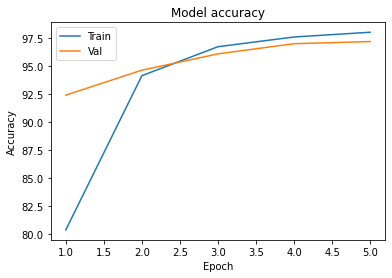

In [ ]:
# Plot training and validation accuracy values
plt.plot(range(1,len(train_accuracy)+1), train_accuracy,label='Train')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = num_classes

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

with torch.no_grad():
    for i, (inputs, classes) in enumerate(valid_data_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

[[ 118    5    0 ...    0    0    0]
 [   0  124    0 ...    0    0    0]
 [   1    1   53 ...    0    0    0]
 ...
 [   0    0    0 ... 1069    0    0]
 [   0    0    0 ...    0   75    0]
 [   0    0    0 ...    0    0  317]]


In [ ]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[ 93.65079365  99.2         96.36363636  99.0881459   98.33887043
  97.63033175  98.83040936  86.40776699  98.32635983  92.89340102
  99.57081545  97.45762712  99.27797834 100.          96.47058824
  99.7277677   95.43478261  98.61111111  94.5         96.62162162
  95.          89.5         96.77419355  97.33333333  99.11591356
  99.18256131  99.0990991   97.82608696  96.47887324  82.
  92.93193717  87.95811518  95.77464789  99.10714286  93.23843416
  99.72014925 100.          99.37304075]


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcbecb94390>)

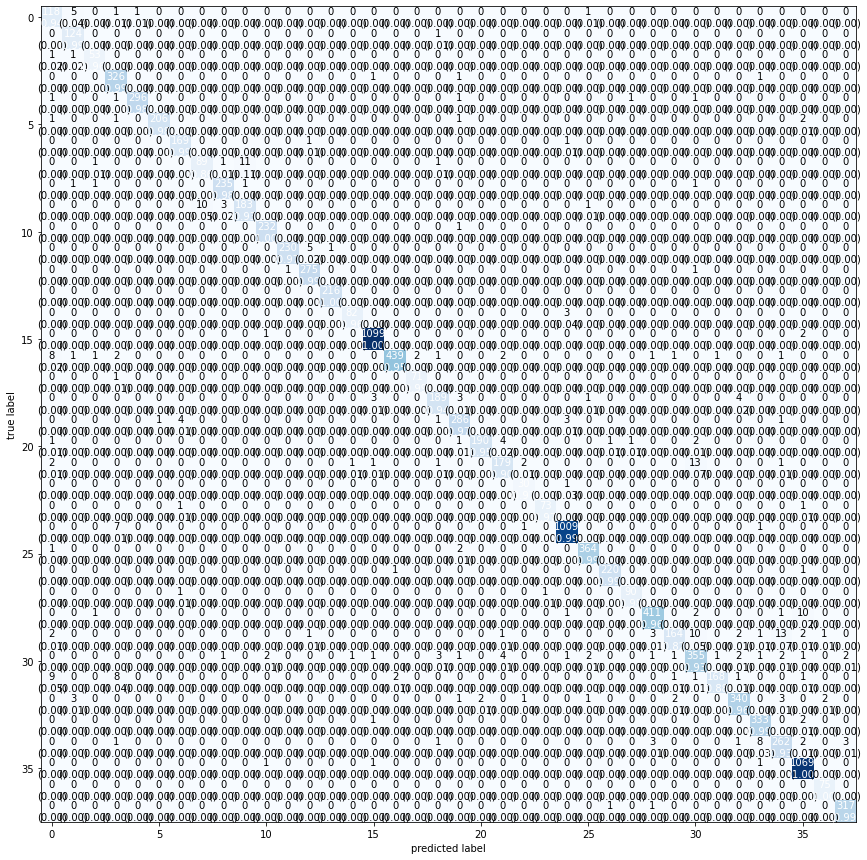

In [ ]:
#mat=confusion_matrix(test_data_gen2.classes,y_pred)
#target_names = ['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
#plot_confusion_matrix(mat,figsize=(26,26),class_names=target_names,show_normed=True)
plot_confusion_matrix(conf_mat,figsize=(15,15),show_normed=True)

In [ ]:
print('Classification Report')
#print(classification_report(test_data_gen.classes, y_pred, target_names=target_names))
print(classification_report(lbllist, predlist))

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       126
           1       0.92      0.99      0.95       125
           2       0.93      0.96      0.95        55
           3       0.94      0.99      0.96       329
           4       1.00      0.98      0.99       301
           5       1.00      0.98      0.99       211
           6       0.97      0.99      0.98       171
           7       0.90      0.86      0.88       103
           8       0.98      0.98      0.98       239
           9       0.94      0.93      0.93       197
          10       0.98      1.00      0.99       233
          11       1.00      0.97      0.99       236
          12       0.98      0.99      0.98       277
          13       1.00      1.00      1.00       216
          14       0.98      0.96      0.97        85
          15       0.99      1.00      1.00      1102
          16       0.99      0.95      0.97       460
     

In [ ]:
# Train
total_step = len(train_data_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % batch_size == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/5], Step [100/435], Loss: 0.0990
Epoch [1/5], Step [200/435], Loss: 0.1895
Epoch [1/5], Step [300/435], Loss: 0.1194
Epoch [1/5], Step [400/435], Loss: 0.1710
Epoch [2/5], Step [100/435], Loss: 0.1011
Epoch [2/5], Step [200/435], Loss: 0.0471
Epoch [2/5], Step [300/435], Loss: 0.1024
Epoch [2/5], Step [400/435], Loss: 0.1168
Epoch [3/5], Step [100/435], Loss: 0.0725
Epoch [3/5], Step [200/435], Loss: 0.0539
Epoch [3/5], Step [300/435], Loss: 0.2116
Epoch [3/5], Step [400/435], Loss: 0.0729
Epoch [4/5], Step [100/435], Loss: 0.0934
Epoch [4/5], Step [200/435], Loss: 0.0422
Epoch [4/5], Step [300/435], Loss: 0.0735
Epoch [4/5], Step [400/435], Loss: 0.1262
Epoch [5/5], Step [100/435], Loss: 0.1329
Epoch [5/5], Step [200/435], Loss: 0.0381
Epoch [5/5], Step [300/435], Loss: 0.1186
Epoch [5/5], Step [400/435], Loss: 0.0729


In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))

Model Accuracy on the 10000 test images: 96.69915410077235 %
